# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.activations import SuperSpike
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import (
    KaimingNormalInitializer,
    FluctuationDrivenCenteredNormalInitializer,
)
from stork.monitors import PopulationFiringRateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import MaxOverTimeCrossEntropy
from stork.plotting import plot_activity_snapshot

from datetime import datetime

import wandb

## Generate Dataset

Specify the Dataset Parameters

In [2]:
# dataset parameters
dim_manifold = 1
nb_sub_classes = 3#5
nb_classes = nb_sub_classes**2
nb_inputs = 20

nb_time_steps = 180
T_delay = 30
sample_duration = 30


nb_samples = 50 # 200
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt


# Model Parameters
batch_size = 600
beta = 20
device = torch.device("cuda:0")
dtype = torch.float


nb_hidden_units = 128 * (nb_inputs * 10 + nb_classes) // (nb_inputs + nb_classes)
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = None
nb_filters = None
lr = 5e-3
nb_epochs = 50

rec = True

# regularizer parameters
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Initializer parameters
sigma_u = 0.3
nu = nb_spikes / duration
gain = None
alpha=0.75

# seeds
seed = 235
np.random.seed(seed)
torch.manual_seed(seed)


dt_format = "%Y-%m-%d_%H:%M:%S"

In [3]:
config = {
    "dataset.dim_mainfold": dim_manifold,
    "dataset.nb_sub_classes": nb_sub_classes,
    "dataset.nb_classes": nb_classes,
    "dataset.nb_inputs": nb_inputs,
    "dataset.nb_time_steps": nb_time_steps,
    "dataset.T_delay": T_delay,
    "dataset.sample_duration": sample_duration,
    "dataset.nb_samples": nb_samples,
    "dataset.nb_spikes": nb_spikes,
    "dataset.alpha": alpha,
    "dataset.randmanseed": randmanseed,
    "dataset.dt": dt,
    "dataset.duration": duration,
    "model.batch_size": batch_size,
    "model.beta": beta,
    "model.device": device,
    "model.dtype": dtype,
    "model.nb_hidden_units": nb_hidden_units,
    "model.tau_mem": tau_mem,
    "model.tau_syn": tau_syn,
    "model.tau_readout": tau_readout,
    "model.tau_filter": tau_filter,
    "model.nb_filters": nb_filters,
    "model.lr": lr,
    "model.nb_epochs": nb_epochs,
    "model.rec": rec,
    "regularizer.lowerBoundL2Strength": lowerBoundL2Strength,
    "regularizer.lowerBoundL2Threshold": lowerBoundL2Threshold,
    "regularizer.upperBoundL2Strength": upperBoundL2Strength,
    "regularizer.upperBoundL2Threshold": upperBoundL2Threshold,
    "initializer.sigma_u": sigma_u,
    "initializer.nu": nu,
    "initializer.gain": gain,
    "initializer.alpha": alpha,
    "seed": seed,
}

In [4]:
wandbrun = wandb.init(
    project="CoRandman-Task-Trials",
    entity="snn-delay",
    config=config,
    name="control",  # + datetime.now().strftime(dt_format),
    mode="disabled"
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Create delay task

In [5]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [6]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [7]:
print(len(ds_train), len(ds_valid), len(ds_test))

18000 2250 2250


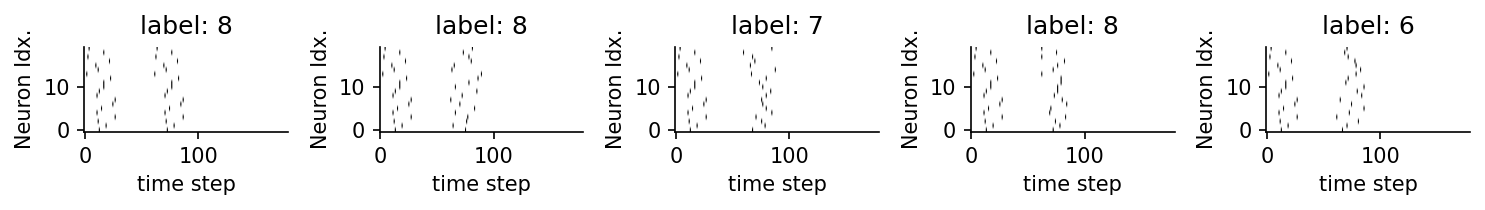

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [9]:
act_fn = SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [10]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [11]:
con = model.add_connection(Connection(input_group, hidden_neurons))
if rec:
    rec_con = model.add_connection(Connection(hidden_neurons, hidden_neurons))

con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [12]:
# Define regularizer list
regs = []

regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [13]:
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, alpha=alpha
)

con.init_parameters(initializer=initializer)
if rec:
    rec_con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [14]:
model.add_monitor(PopulationFiringRateMonitor(model.groups[1]))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [15]:
loss_stack = MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [16]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [17]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
    wandb=wandbrun,
)

Before we train the model, we monitor the spikes

In [18]:
# Monitors spike counts before training
res = model.monitor(ds_test)

In [19]:
before_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y]
    for (x, y) in zip(np.linspace(0, duration, nb_time_steps), before_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "before_mean_pop_fr"])
wandb.log(
    {
        "before_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "before_mean_pop_fr",
            title="Mean Population Firing Rate (before training)",
        )
    }
)

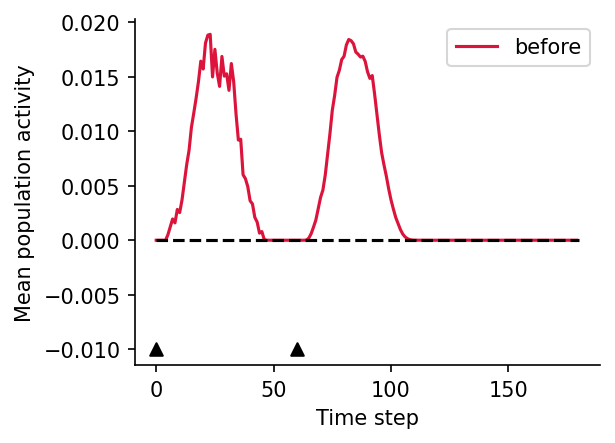

In [20]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")

plt.hlines(0, 0, before_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

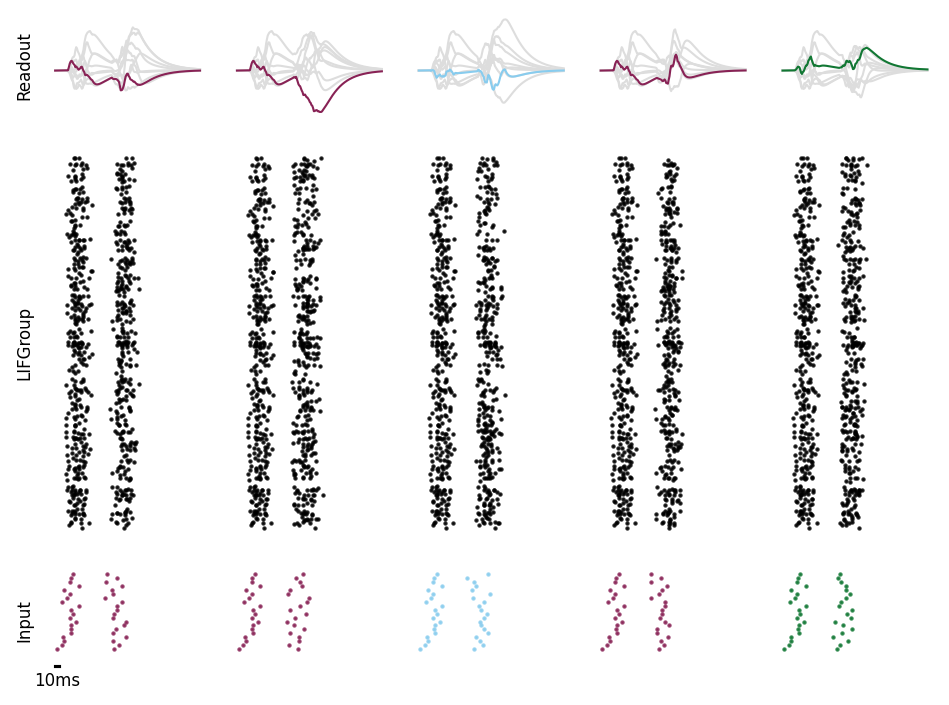

In [21]:
plt.figure(dpi=150)
plot_activity_snapshot(model, data=ds_test, point_alpha=0.8, show_predictions=False)

## Training


In [22]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

00  loss=2.12 reg_loss=0.0493 acc=0.266 -- val_loss=1.74 val_reg_loss=5.14e-05 val_acc=0.264 t_iter=19.04
01  loss=1.25 reg_loss=0.0554 acc=0.324 -- val_loss=1.47 val_reg_loss=5.86e-05 val_acc=0.292 t_iter=18.56
02  loss=1.14 reg_loss=7.47e-05 acc=0.321 -- val_loss=1.45 val_reg_loss=1.06e-05 val_acc=0.312 t_iter=19.16
03  loss=1.13 reg_loss=0.000534 acc=0.318 -- val_loss=1.44 val_reg_loss=1.28e-05 val_acc=0.292 t_iter=19.46
04  loss=1.11 reg_loss=1.83e-05 acc=0.318 -- val_loss=1.38 val_reg_loss=1.82e-05 val_acc=0.312 t_iter=20.87
05  loss=1.11 reg_loss=3e-05 acc=0.316 -- val_loss=1.32 val_reg_loss=2.15e-05 val_acc=0.312 t_iter=19.35
06  loss=1.11 reg_loss=4.63e-05 acc=0.317 -- val_loss=1.36 val_reg_loss=7.26e-05 val_acc=0.312 t_iter=19.19
07  loss=1.11 reg_loss=8.54e-05 acc=0.319 -- val_loss=1.34 val_reg_loss=0.000432 val_acc=0.311 t_iter=18.70
08  loss=1.11 reg_loss=9.89e-05 acc=0.323 -- val_loss=1.33 val_reg_loss=1.07e-06 val_acc=0.292 t_iter=18.86
09  loss=1.11 reg_loss=3.15e-05 acc

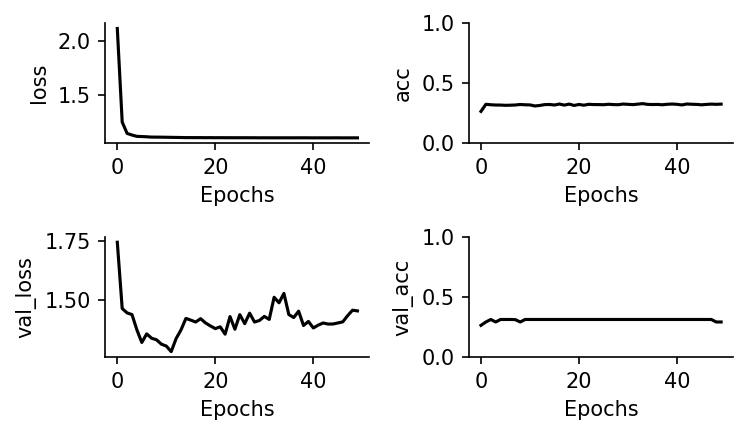

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["loss", "acc", "val_loss", "val_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(history[n].tolist(), color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

## Test

In [24]:
scores = model.evaluate(ds_test).tolist()
wandbrun.log({"test_loss": scores[0], "test_acc": scores[2]})

In [25]:
print("Test loss: ", scores[0])
print("Test acc.: ", round(scores[2] * 100, 2), "%")


print("Valid loss: ", history["val_loss"].tolist()[-1])
print("Valid acc.: ", round(history["val_acc"].tolist()[-1] * 100, 2), "%")

history.clear()

Test loss:  1.3142264187335968
Test acc.:  28.47 %
Valid loss:  1.45575550198555
Valid acc.:  29.17 %


#### Monitor the model again after training

In [26]:
res = model.monitor(ds_test)

In [27]:
after_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y]
    for (x, y) in zip(np.linspace(0, duration, nb_time_steps), before_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "after_mean_pop_fr"])
wandb.log(
    {
        "after_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "after_mean_pop_fr",
            title="Mean Population Firing Rate (after training)",
        )
    }
)

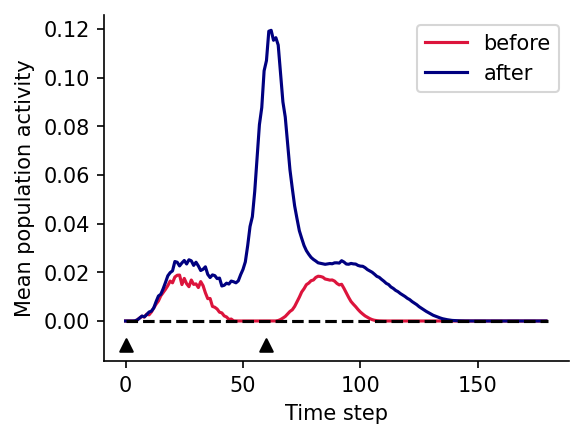

In [28]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.plot(after_mean_pop_fr, color="navy", label="after")

plt.hlines(0, 0, after_mean_pop_fr.shape[0], linestyle="--", color="black")

plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

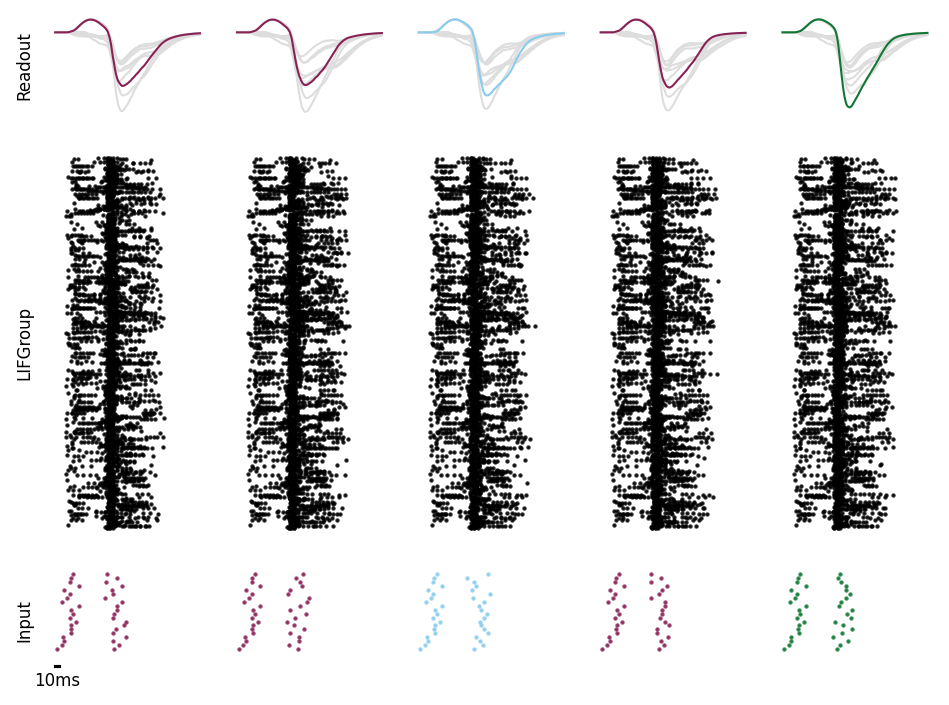

In [29]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)

In [30]:
wandbrun.finish()